In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [49]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [50]:
!wget $data

--2025-10-31 18:42:51--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.1’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.03s   

2025-10-31 18:42:51 (2.48 MB/s) - ‘course_lead_scoring.csv.1’ saved [80876/80876]



In [51]:
df = pd.read_csv('course_lead_scoring.csv')

In [52]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


## Data Preparation

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [ ]:
df.isna().sum()

,0
lead_source,128
industry,134
number_of_courses_viewed,0
annual_income,181
employment_status,100
location,63
interaction_count,0
lead_score,0
converted,0


In [53]:
categorical = df.select_dtypes(include='object').columns
df[categorical] = df[categorical].fillna('NA')

numerical = df.select_dtypes(include='number').columns
df[numerical] = df[numerical].fillna(0)
df.isna().sum()

,0
lead_source,0
industry,0
number_of_courses_viewed,0
annual_income,0
employment_status,0
location,0
interaction_count,0
lead_score,0
converted,0


In [54]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [55]:
y_train = df_train['converted']
y_val = df_val['converted']
y_test = df_test['converted']

In [56]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [57]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = df_train[list(categorical) + list(numerical)].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)


val_dict = df_val[list(categorical) + list(numerical)].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[list(categorical) + list(numerical)].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [58]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [59]:
y_pred = model.predict_proba(X_val)[:,1]
converted_decision = (y_pred >= 0.5)
(y_val == converted_decision).mean()

np.float64(0.7713310580204779)

### Accuracy and dummy model

In [60]:
 # accuracy is number of correct predictions devided by the total number of employment
(y_val == converted_decision).sum()

np.int64(226)

In [61]:
len(y_val)

293

In [62]:
thresholds = np.linspace(0, 1, 21)

scores = []
for t in thresholds:
  score = accuracy_score(y_val, y_pred >= t)
  print('%.2f %.3f ' % (t, score))
  scores.append(score)

0.00 0.584 
0.05 0.584 
0.10 0.584 
0.15 0.584 
0.20 0.587 
0.25 0.597 
0.30 0.597 
0.35 0.642 
0.40 0.676 
0.45 0.727 
0.50 0.771 
0.55 0.795 
0.60 0.805 
0.65 0.799 
0.70 0.761 
0.75 0.713 
0.80 0.669 
0.85 0.601 
0.90 0.532 
0.95 0.447 
1.00 0.416 


Text(0.5, 0, 'threshold')

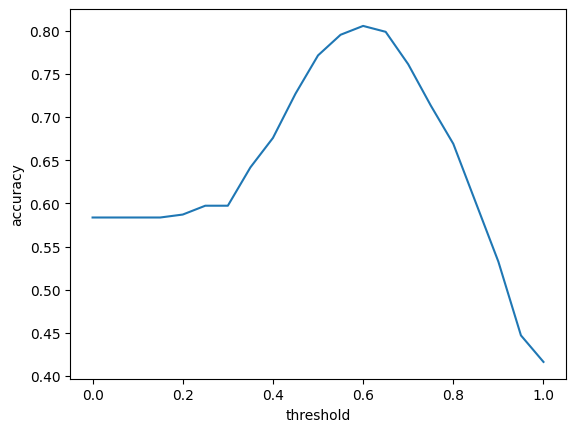

In [63]:
plt.plot(thresholds, scores)
plt.ylabel('accuracy')
plt.xlabel('threshold')

In [64]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, y_pred >= 0.5)

0.7713310580204779

## Confusion Table

In [65]:
#confusion table is a way of looking at differnt errors and correct decisions that a binary classification model make
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

predicted_positive = (y_pred >= 0.5)
predicted_negative = (y_pred < 0.5)

In [66]:
tp = (predicted_positive & actual_positive).sum()
tn = (predicted_negative & actual_negative).sum()
fp = (predicted_positive & actual_negative).sum()
fn = (predicted_negative & actual_positive).sum()

In [67]:
tp , tn , fp , fn

(np.int64(168), np.int64(58), np.int64(64), np.int64(3))

In [68]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[ 58,  64],
       [  3, 168]])

## Precision and Recall

In [69]:
#Precision tells you, out of all the times the model said "positive,"
#how many times it was actually right. So, it's about how trustworthy
#the positive predictions are.
precision = tp / (tp + fp)
precision

np.float64(0.7241379310344828)

In [70]:
#Recall tells you, out of all the true positive cases that really exist,
#how many the model correctly found. So, it's about how many of the actual positives
# were caught by the model.
recall = tp / (tp + fn)
recall

np.float64(0.9824561403508771)

## Question 1

In [71]:
from sklearn.metrics import roc_auc_score

features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
y_true = df_train['converted']

for feature in features:
    scores = df_train[feature]
    auc = roc_auc_score(y_true, scores)
    if auc < 0.5:
        scores = -scores  # negate the feature values
        auc = roc_auc_score(y_true, scores)
    print(f"Feature: {feature}, AUC: {auc:.3f}")

Feature: lead_score, AUC: 0.614
Feature: number_of_courses_viewed, AUC: 0.764
Feature: interaction_count, AUC: 0.738
Feature: annual_income, AUC: 0.552


## Question 2

In [72]:
y_pred = model.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_pred)
print(f'Validation AUC: {auc:.3f}')

Validation AUC: 0.877


## Question 3

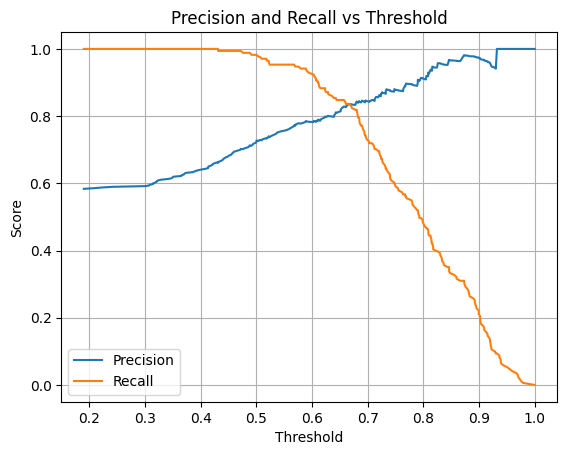

In [73]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

thresholds = np.append(thresholds, 1.0)

plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# ROC Curves: Receiver operating characteristic
### a way of describing the performance of a binary classification model ( how model behave with diff treshholds)
### Why ROC AUC Matters
- Threshold Independence: Unlike accuracy, precision, or F1-score, ROC AUC evaluates model performance across all possible classification thresholds, not just one fixed threshold.​

- Model Comparison: It gives a single scalar value (the area under the ROC curve), making it easy to compare different models, even if they have different optimal thresholds.​

- Robustness to Class Imbalance: ROC AUC is less sensitive to class imbalance than metrics like accuracy, which can be misleading when one class dominates the dataset.​

- Insight into Model Discrimination: The ROC curve plots the true positive rate (sensitivity) against the false positive rate (1 - specificity) at various thresholds, showing how well the model separates the two classes

In [74]:
fpr = fp / (fp + tn)
fpr

np.float64(0.5245901639344263)

In [75]:
tpr = tp/ (tp + fn)
tpr

np.float64(0.9824561403508771)

Instead of evaluating TPR? FPR for one threshold, we'll evaluate them for all possible thresholds

In [76]:
thresholds = np.linspace(0, 1, 101)

scores = [] # Clear the scores list

for t in thresholds:
  actual_positive = (y_val == 1)
  actual_negative = (y_val == 0)

  predicted_positive = (y_pred >= t)
  predicted_negative = (y_pred < t)

  tp = (predicted_positive & actual_positive).sum()
  fp = (predicted_positive & actual_negative).sum()
  fn = (predicted_negative & actual_positive).sum()
  tn = (predicted_negative & actual_negative).sum()

  scores.append((t,tp,fp, fn, tn))


In [77]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [78]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [79]:
df_scores[::10] #from the first record to the last record with increments of 10

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,171,122,0,0,1.000000,1.000000
10,0.1,171,122,0,0,1.000000,1.000000
20,0.2,171,121,0,1,1.000000,0.991803
30,0.3,171,118,0,4,1.000000,0.967213
40,0.4,171,95,0,27,1.000000,0.778689
50,0.5,168,64,3,58,0.982456,0.524590
60,0.6,158,44,13,78,0.923977,0.360656
70,0.7,124,23,47,99,0.725146,0.188525
80,0.8,82,8,89,114,0.479532,0.065574
90,0.9,35,1,136,121,0.204678,0.008197


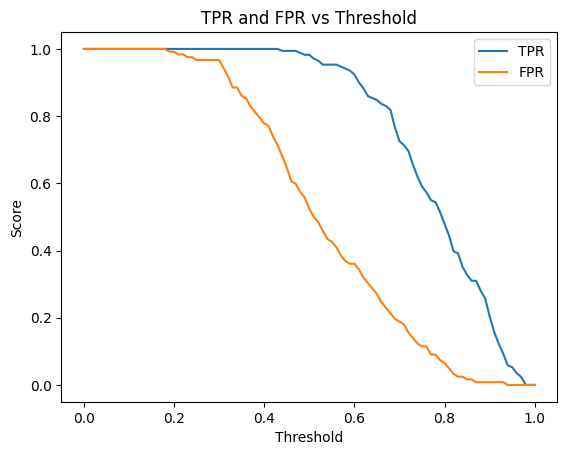

In [80]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('TPR and FPR vs Threshold')
plt.legend()

## Random model

In [81]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, len(y_val))

In [82]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.48464163822525597)

In [83]:
def tpr_fpr_dataframe(y_val, y_pred):
  scores = []
  thresholds = np.linspace(0, 1, 101)
  for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predicted_positive = (y_pred >= t)
    predicted_negative = (y_pred < t)

    tp = (predicted_positive & actual_positive).sum()
    fp = (predicted_positive & actual_negative).sum()
    fn = (predicted_negative & actual_positive).sum()
    tn = (predicted_negative & actual_negative).sum()

    scores.append((t,tp,fp, fn, tn))

  columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

  df_scores = pd.DataFrame(scores, columns=columns)
  df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
  df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

  return df_scores


In [85]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,171,122,0,0,1.000000,1.000000
10,0.1,153,108,18,14,0.894737,0.885246
20,0.2,135,96,36,26,0.789474,0.786885
30,0.3,120,87,51,35,0.701754,0.713115
40,0.4,105,78,66,44,0.614035,0.639344
50,0.5,90,70,81,52,0.526316,0.573770
60,0.6,68,55,103,67,0.397661,0.450820
70,0.7,47,43,124,79,0.274854,0.352459
80,0.8,36,30,135,92,0.210526,0.245902
90,0.9,18,18,153,104,0.105263,0.147541


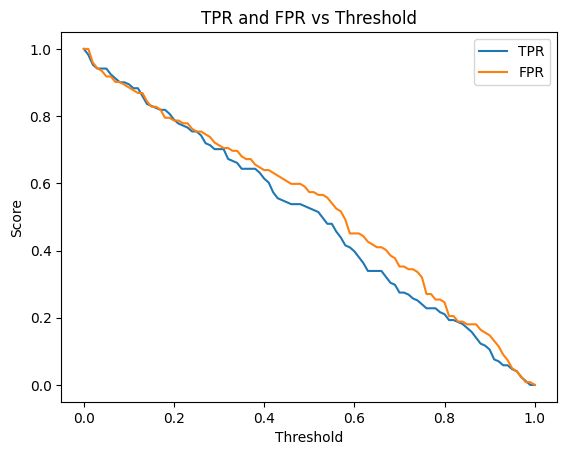

In [86]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('TPR and FPR vs Threshold')
plt.legend()

## Ideal Model: orders scores

In [87]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(122), np.int64(171))

In [88]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])

In [89]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [90]:
((y_ideal_pred >= 0.4) == y_ideal).mean()

np.float64(0.9829351535836177)

In [91]:
df_ideal = tpr_fpr_dataframe(y_val, y_ideal_pred)

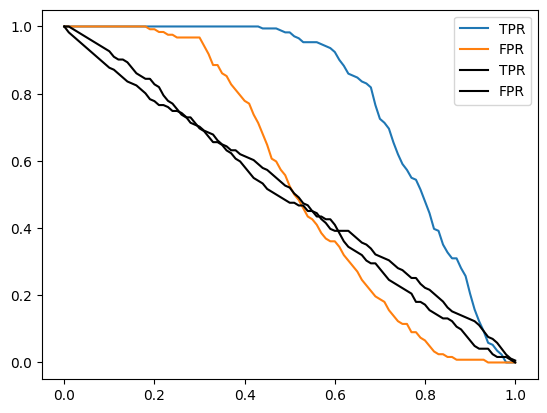

In [94]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')

#plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
#plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')

plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR', color='black')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR', color='black')
plt.legend()

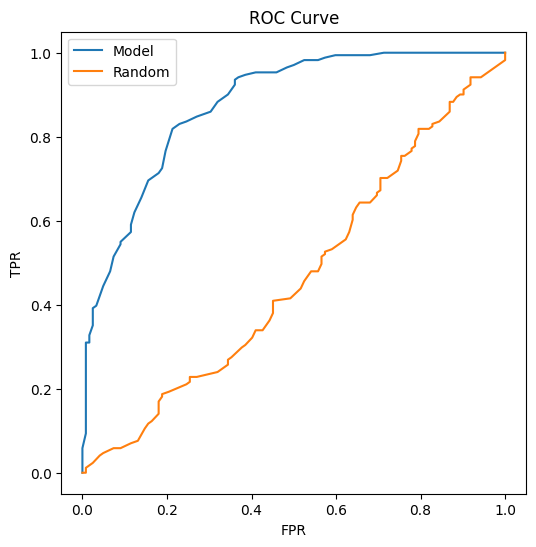

In [101]:
plt.figure(figsize=(6, 6))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, label='Random')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()

## - If our model's curve is close to the random model's curve, then it's not a good model, it must be as close as possible to the idea spot which is 1, meaning the model makes less mistakes
## - We start with threshold = 1 and then it gets smaller, until it reachs 0.0 when TPR and FPR reach 1.0

In [99]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

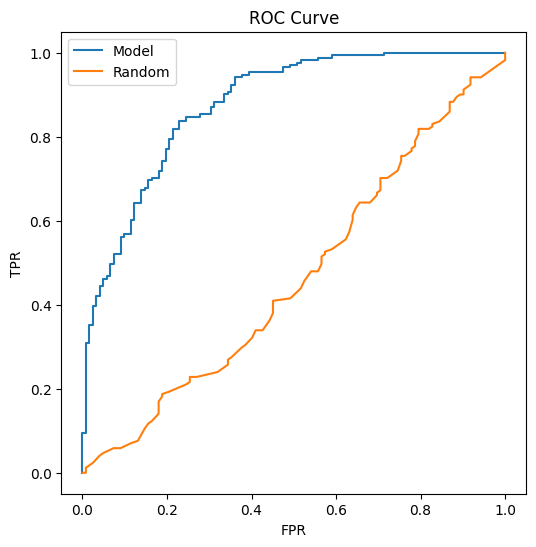

In [100]:
plt.figure(figsize=(6, 6))

plt.plot(fpr,tpr, label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, label='Random')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()

## Question 4

In [ ]:
F1 = 2 * (precision * recall) / (precision + recall)

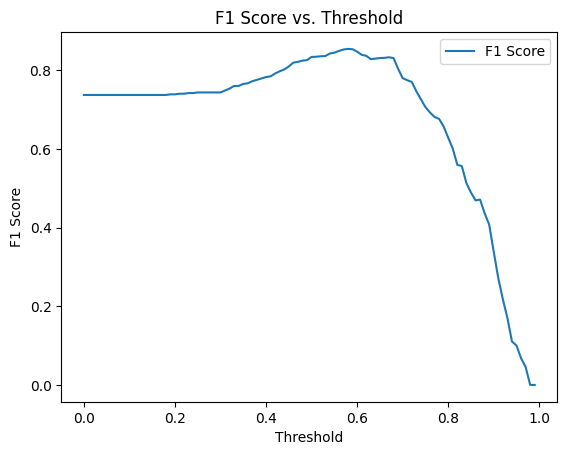

In [ ]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_thresholded = (y_pred >= t).astype(int)
    precision = precision_score(y_val, y_pred_thresholded)
    recall = recall_score(y_val, y_pred_thresholded)
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    f1_scores.append(f1)


plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.show()

# Cross Validation


In [ ]:
def train(df_train, y_train, C=1.0):
  dicts = df_train[list(categorical) + list(numerical)].to_dict(orient='records')

  dv = DictVectorizer(sparse=False)
  X_train = dv.fit_transform(dicts)

  model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
  model.fit(X_train, y_train)

  return dv, model

In [ ]:
dv, model = train(df_train, y_train,C=0.001)

In [ ]:
def predict(df, dv, model):
  dicts = df[list(categorical) + list(numerical)].to_dict(orient='records')

  X = dv.transform(dicts)
  y_pred = model.predict_proba(X)[:,1]

  return y_pred

In [ ]:
y_pred = predict(df_val, dv, model)

## Question 5

In [ ]:
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for train_idx, val_idx in kfold.split(df_full_train):
  df_train = df_full_train.iloc[train_idx]
  df_val = df_full_train.iloc[val_idx]

  y_train = df_train['converted']
  y_val = df_val['converted']

  dv, model = train(df_train, y_train, C=0.001)
  y_pred = predict(df_val, dv, model)
  auc = roc_auc_score(y_val, y_pred)
  scores.append(auc)

In [ ]:
scores

[np.float64(0.8688304920717635),
 np.float64(0.9216514191883649),
 np.float64(0.8433810305731487),
 np.float64(0.8422322540473225),
 np.float64(0.9026466491255224)]

In [ ]:
print('%.6f +- %.6f' % (np.mean(scores), np.std(scores)))

0.875748 +- 0.031779


## Question 6

In [ ]:
n_splits = 5
for C in [0.000001, 0.001, 1]:
  scores = []
  kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

  for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['converted']
    y_val = df_val['converted']

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
  print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 0.562 +- 0.024
C=0.001 0.937 +- 0.013
C=1 1.000 +- 0.000
